# CSPB 3202 Final Project #

Tyler Kinkade, Tyler.Kinkade@colorado.edu    

_All rights reserved_

GitHub: [https://github.com/jaki9292/rl-project](https://github.com/jaki9292/rl-project)

## Overview ##

This write-up reports on a small project to compare the effectiveness of artificial agent algorithms ranging in sophistication from naive to deep reinforcement learning (Russell & Norvig, 2022; Sutton & Barto, 2018) to successfully land a virtual "lunar lander" in a Gymnasium (2022) model environment. After comparing the various models, I explore the effects of various hyperparameters on a deep Q-network model (Mnih et al., 2015).

The report is divided into three main sections: approach, results, and discussion.

## Approach ##

My approach to the problem is described in the following environment, models, and methods subsections.

### Environment ###

The lunar lander environment (pictured below) simulates rocket trajectory physics with the primary aim of landing a lunar lander on a central landing pad (marked by two flags) by means of turning its three rocket thrusters (left, right, and main) on or off. The agent operating the lander is rewarded for landing slowly, in an upright position, on both legs, on or near the landing pad and penalized otherwise. Fuel is unlimited, but a penalty is given for each time an engine fires. Episodes are truncated after 1000 time-steps. Scores of 200 points or more are considered a solution. 

The state space is described by an 8-vector comprised of the lander coordinates $(x,y)$, its linear velocities $(v_x,v_y)$ in the $x$ and $y$ directions, its angle $(\theta)$, its angular velocity $(\omega)$, and two Boolean variables $(l,r)$ that encode whether the left and right legs are in contact with the ground. The environment has both discrete and continuous versions, but only the discrete version is used here, in order to include simple models in the comparison. The environment gravity, wind power, and turbulence can also be specified. The starting state is the top center of the space with a random force applied to the lander. The termination state occurs when the lander stops moving or moves outside the frame. The action space is comprised of 4 discrete actions: do nothing, fire left thruster, fire main down thruster, or fire right thruster.

In [1]:
# Display Lunar Lander GIF
from IPython.display import Image
Image(url= "https://gymnasium.farama.org/_images/lunar_lander.gif")

In [2]:
# Install dependencies
# Packages preinstalled on Google Colab:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install torch

# Packages not pre-installed on Google Colab:
# !pip install moviepy
# !pip install torchinfo
# !pip install ufal.pybox2d
# !pip install gymnasium
# !pip install gymnasium[box2d]

In [3]:
# Display environment parameters
# References: 
# https://gymnasium.farama.org/api/env/
# https://gymnasium.farama.org/environments/box2d/lunar_lander/

import gymnasium as gym

# Initialize environment
env = gym.make("LunarLander-v2", 
               continuous = False,      # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array") # Render for machine

# Reset environment with random number generator seed for reproducibility
state, info = env.reset(seed = 21)

print("Environment metadata:\n", env.metadata)
print("\nState space:\n", env.observation_space)
print("\nAction space:\n", env.action_space)
print("\nStarting state:\n", state)

Environment metadata:
 {'render_modes': ['human', 'rgb_array'], 'render_fps': 50}

State space:
 Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

Action space:
 Discrete(4)

Starting state:
 [ 0.00786695  1.4032904   0.796822   -0.33911794 -0.00910905 -0.18049194
  0.          0.        ]


The table below summarizes the descriptive statistics for 100 randomly sampled initial states for this environment. We can see that the initial linear and angular velocities vary more than the position and angular orientation.

In [4]:
import pandas as pd

# Determine average starting state from 100 random samples
starting_states = []
for _ in range(100):
    starting_state, info = env.reset()
    starting_states.append(starting_state)

features = ['x','y','vx','vy','angle','ang_vel','left_leg','right_leg']
starting_states_df = pd.DataFrame(starting_states, columns = features)
starting_states_df.describe()

,x,y,vx,vy,angle,ang_vel,left_leg,right_leg
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0
mean,-0.000202,1.410030,-0.020460,-0.039560,0.000241,0.004635,0.0,0.0
std,0.004445,0.007046,0.450270,0.313165,0.005151,0.101993,0.0,0.0
min,-0.007806,1.398572,-0.790636,-0.548822,-0.009096,-0.180236,0.0,0.0
25%,-0.003390,1.404051,-0.343335,-0.305285,-0.003875,-0.076865,0.0,0.0
50%,-0.000128,1.409595,-0.012973,-0.058933,0.000155,0.002939,0.0,0.0
75%,0.003350,1.416666,0.339339,0.255355,0.003934,0.077771,0.0,0.0
max,0.007856,1.421770,0.795693,0.482209,0.009052,0.179091,0.0,0.0


### Models ###
Four models are compared in this project: an agentless lunar lander, a random agent, a simple reflex agent, and a deep Q-network agent. 

#### Agentless Lunar Lander ####
An agentless lunar lander takes no action and is at the complete mercy of its environment. Because the starting state is directly above the landing pad, this might not be as terrible a strategy as it initially seems. The lander will simply fall to the ground in a trajectory determined by the physics of the environmental forces and the initial force placed upon it.

#### Random Agent ####

A random agent selects any of the possible actions uniformly randomly at each step without regard to the environment. The animation above is an example of such an agent and appears to be a poor strategy. Is this a worse strategy than an agentless lander though?

#### Simple Reflex Agent ####

A simple reflex agent can only react in a fixed way to sensory input but does not retain any memory of the past and, as a result, cannot learn (Russell & Norvig, 2022). As explained in the environment section, the initial lunar lander position is generally centered above the landing pad, but there is wide variation in initial linear and angular velocity. Thus, the primary task is counteracting any horizontal velocity while at the same time, avoiding turning the ship on its side. Therefore, there is a balance to be achieved, and the programmer must select appropriate threshold constants for the algorithm. Depending on the algorithm and constants, this could potentially be a better strategy than doing nothing or acting randomly.

#### Deep Q-Network Agent ####

A deep Q-network (DQN; Mnih et al., 2015, 2016) agent is a deep-learning neural network approximation of a Q-learning agent (Russell & Norvig, 2022; Sutton & Barto, 2018). A Q-learning agent alternates between learning through exploration and exploiting what it has learned by choosing the action with maximal value for each state. Although this is obviously better than the relatively ignorant reflex agent, Q-learning agents can quickly become computationally expensive and slow to learn in large and complex environments (Russell & Norvig, 2022; Sutton & Barto, 2018). 

Approximate Q-learning agents address this problem by approximating the Q-value of actions in particular states with a weighted feature function based on states and actions (Russell & Norvig, 2022; Sutton & Barto, 2018). However, in the environment in this project, we only have access to the current features and do not know with certainty how any particular action will influence those features. 

Fortunately, the universal approximation theorem tells us that we can approximate any function with a neural network of at least two layers  (Russell & Norvig, 2022). Thus, we can approximate a Q-value function with a DQN by recording a log of previous attempts (i.e., replay buffer) to train the model (Paszke & Towers, 2017). In other words, the agent remembers and learns from its experiences. In addition, this allows us to sample randomly from the buffer to reduce variance (Morales, 2020). Value gradient clipping will be used to avoid exploding gradients (Goodfellow et al., 2016).

For this project, the DQN consists of three fully-connected neural network layers. A non-linear activation function is placed between the layers to prevent the model from collapsing into a one-layer linear model. Here, a rectified linear unit (ReLU) function is selected for this because of its computational simplicity and its consistent, demonstrated effectiveness in previous studies (Goodfellow et al., 2016; Karpathy, 2016). The inputs to the network are the eight state features and the output is a vector of approximate Q-values for each of the four possible actions given the input state. 

It is worth noting that image-based convolutional neural networks are frequently used for DQNs (e.g., Mnih et al., 2015). However, I am interested here in solving the lunar landing problem from the perspective of the sensory information available to an agent within the lunar lander, rather than an outside observer.

Another design choice is how often the agent should explore versus how often it should exploit what it has learned thus far. For this project, I will use an epsilon-greedy policy which prioritizes learning at the beginning but gradually shifts to prioritizing the highest rewards by selecting the policy it has learned thus far.

To train the model, I will use the Huber loss function (Huber, 1964), which is more robust to noisy data than mean-squared error for training the model (Paszke & Towers, 2017).For optimization, I will use the AdamW optimization algorithm (Loshchilov & Hutter, 2019). Unlike the stochastic gradient descent algorithm, Adam optimization maintains and adapts separate learning rates for each parameter (Brownlee, 2017). AdamW improves upon this by decoupling weight decay from the gradient update (Loshchilov & Hutter, 2019). Gradient clipping will be used to avoid exploding gradients (Goodfellow et al., 2016).

A potential problem with training DQNs is that parameter updates cause the targets to shift leading to divergence away from an optimal policy (Morales, 2020). To counteract this two networks of parameters are used: an online network which is updated every iteration and a target netowrk which is updated less frequently, or at a specified rate $\tau$, and whose Q-values are used to calculate the loss and train the online set. This allows the parameters to stabilize.

It is expected that the DQN model will perform better than the first three; however, it is still possible that some difficulties might arise in creating a neural network which converges to an optimal policy.

### Methods ###

The first three models do not require training, so they will only be run for 100 episodes because their average score will not differ significantly after even more episodes. The DQN model will likely require more training as well as hyperparameter tuning. For all models, the single-episode truncation will be reduced to 600 time-steps in order to decrease the training time.

The scores over each of the episodes will be plotted and compared. Visualizing each model's performance over successive episodes permits comparison of how each agent progressed in learning how to solve the model. As Machado and his colleagues (2018) point out, this is preferable to single metrics, such as maximum or average scores which can conceal important distinctions. For example, we can discover whether an agent achieved a maximum only once, but performed poorly most of the time. Similarly, an average score can conceal unstable, fluctuating performance. Ideally, we would like to see an agent learning quickly and then stably maintaining high scores above the solution threshold of 200 points.

Applying this methodology, we will be able to explore the advantages and disadvantages of the various models and also demonstrate how a solution to the problem can be explored through the modfication of features and comparison of models.

In the following code blocks, I construct the Python classes required to implement each of the agents.

#### Agentless Lunar Lander ####
The following code implements an agentless lunar lander which never fires any of its thrusters. This will also be used as the base class for the other agents.

In [5]:
# Define general lunar lander class
#
# Adapted from: 
# CSPB 3202 Gym tutorial (https://applied.cs.colorado.edu/mod/folder/view.php?id=43136)
# https://gymnasium.farama.org/
# https://gymnasium.farama.org/api/utils/#save-rendering-videos
# https://gymnasium.farama.org/environments/box2d/lunar_lander/
# https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
#
# Additional references:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.isinteractive.html
# https://www.statology.org/matplotlib-inline/
# https://www.tutorialspoint.com/how-to-check-that-pylab-backend-of-matplotlib-runs-inline
# https://learnpython.com/blog/average-in-matplotlib/

from gymnasium.utils.save_video import save_video
import numpy as np
from IPython.utils.capture import capture_output
import matplotlib
import matplotlib.pyplot as plt

# Display graphs inline
%matplotlib inline

# Check if inline display is possible
is_ipython = 'inline' in matplotlib.get_backend()

# If Jupyter notebook
if is_ipython:
    from IPython import display

class LunarLander:
    '''
    General lunar lander class 
    subject entirely to its environment
    '''   
    def __init__(self, name = "Agentless Lander", step_limit = 600):
        '''
        Initialize agent
        '''
        self.name = name
        self.prefix = "-".join(name.split()).lower() # filename prefix
        self.step_limit = step_limit  # max. allowed steps/episode

        # Initialize environment
        self.env = gym.make("LunarLander-v2", 
               continuous = False,           # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array_list") # Render for machine

        # Define actions
        self.NOOP = 0   # No operation (i.e., do nothing)
        self.LEFT = 1   # Fire left orientation engine
        self.MAIN = 2   # Fire main downward engine
        self.RIGHT = 3  # Fire right orientation engine

        # Reset environment with random number generator seed for reproducibility
        self.state, self.info = self.env.reset(seed = 21)
        
        # Set environment dimensions
        self.features_size = len(self.state)
        self.actions_size = env.action_space.n
  
        # Initialize data logs
        self.scores = []
        self.steps = []
        self.policy = []

        # Initialize total iteration step count
        self.total_steps = 0

        # Initialize parameters needed for reinforcement learning agents
        # to prevent errors. These will not be used for non-RL agents
        self.memory = [] 
        self.batch_size = 1
        self.scheduler = None

    def select_action(self, state):
        '''
        Select action given state
        '''
        # Do nothing
        return self.NOOP

    def episode(self):
        '''
        Complete episode in given environment
        Return score, steps count, and actions log
        '''
        # Initialize rewards total
        score = 0.0

        # Initialize steps count
        episode_steps = 0

        # Initialize actions list
        actions = []

        # Start new episode  
        state, info = self.env.reset()

        # Until end of episode
        while True:
            # Get action based on current state
            action = self.select_action(state)

            # Obtain next state, reward, terminated status, truncated status, 
            # and environment info for given action
            next_state, reward, terminated, truncated, info = self.env.step(action)
            
            # Accumulate reward total
            score += reward

            # Increment episode steps
            episode_steps += 1

            # Increment overall step count
            self.total_steps += 1

            # Record action
            actions.append(action)

            # If number of steps has been surpassed or end of episode
            if (episode_steps > self.step_limit) or terminated or truncated:
                break  # out of loop
            
            # Advance to next state 
            state = next_state

        return score, episode_steps, actions
    
    def iterate(self, n = 100,      # Number of iterations
                verbose = False,    # Print results for each episode
                video = False,      # Output videos of (k^3)th episodes
                plot = True):       # Display plot updated every episode
        '''
        Attempt task for n episodes
        '''
        # Enable interactive plotting
        plt.ion()

        # Counter for indexing start of videos
        video_step_start = 0

        # Repeat n times
        for episode in range(n):
            # Complete one episode
            score, episode_steps, actions = self.episode()
            
            # Log scores, steps, policy
            self.scores.append(score)
            self.steps.append(episode_steps)
            self.policy.append(actions)

            # If there are at least buffer_size transitions 
            # in the buffer memory
            if (len(self.memory) >= self.batch_size):                        
                # Increment learning rate scheduler count
                # Scheduler will perform learning rate decrement
                # after kth episode specified in lr_period parameter 
                self.scheduler.step()
            
            if plot:
                # Update training plot
                self.plot_scores()

            if verbose:
                # Report result
                print(f"Episode {episode} score: {score}")

            if video:
                # Suppress MoviePy stdout
                # https://stackoverflow.com/a/35624406/14371011
                with capture_output() as captured:
                    # Save mp4 of every (k^3)th episode (0, 1, 8, 27, ...)
                    save_video(self.env.render(),
                               video_folder = "videos",
                               name_prefix = self.prefix,
                               fps = env.metadata["render_fps"],
                               step_starting_index = video_step_start,
                               episode_index = episode)

            # Advance starting step index for videos
            video_step_start = episode_steps + 1           
        
        if plot:
            # Plot final result
            self.plot_scores(show_result = True)
            plt.show() # Display plot

        # Disable interactive plotting
        plt.ioff() 
    
    def score_stats(self, verbose = False):
        '''
        Return mean, max, and min of scores if they exist 
        '''
        # If scores exist
        if (len(self.scores) > 0):
            # Calculate average, max, and min score
            average = np.average(self.scores)
            max = np.max(self.scores)
            min = np.min(self.scores)
            
            # Calculate average episode length
            avg_length = np.average(self.steps)

            if verbose:
                # Report average, max, and min
                print(f"\nAverage score: {average:.1f}") 
                print(f"Maximum score: {max:.1f}")
                print(f"Minimum score: {min:.1f}")
                print(f"Average episode length: {avg_length:.1f}")

            return average, max, min, avg_length
        else: 
            print("No scores have been calculated")
            return None, None, None
        
    def plot_scores(self, show_result = False):
        '''
        Dynamically plot episode scores
        Plot running average at conclusion 
        '''
        # Initialize plot
        plt.figure(1)

        # If not final plot
        if not show_result:
            # Clear current figure
            plt.clf()

        # Plot solution threshold
        plt.axhline(y = 200, color = "r", linestyle = "dashed", label = "Solution Threshold")  

        # Plot episode-by-episode scores
        plt.plot(self.scores, label = self.name)
        plt.title(self.name)
        plt.xlabel("Episode")
        plt.ylabel("Score")

        # If final plot
        if show_result:
            # Plot running average

            # Span for running average
            window = 25
            
            # Initialize list with one fewer NaNs than window
            averages = [np.nan] * (window - 1)

            # Calculate running average
            for idx in range(len(self.scores) - window + 1):
                averages.append(np.mean(self.scores[idx : idx + window]))

            # Plot running average
            plt.plot(averages, color = "k", label = "Running Average")

        plt.legend()

        # Pause to allow plot to update
        plt.pause(0.001)

        # If Jupyter notebook
        if is_ipython:
            if not show_result:
                # Display plot
                display.display(plt.gcf())
                # Clear plot when done
                display.clear_output(wait = True)
            else:
                # Display plot
                display.display(plt.gcf())

In [6]:
# Video clips are saved in cubic intervals of episodes, so for reference, the first 41 cubes (from https://oeis.org/A000578) are:
cubes = [0, 1, 8, 27, 64, 125, 216, 343, 512, 729, 1000, 1331, 1728, 2197, 2744, 3375, 4096, 4913, 5832, 6859, 8000, 9261, 10648, 12167, 13824, 15625, 17576, 19683, 21952, 24389, 27000, 29791, 32768, 35937, 39304, 42875, 46656, 50653, 54872, 59319, 64000]
len(cubes)

41

#### Random Agent ####
The following coe implements an agent which selects any of the four possible actions randomly at each time step:

In [7]:
# Define random agent class

class RandomAgent(LunarLander):
    '''
    Inherits from lunar lander class
    and acts randomly
    '''
    def __init__(self, name = "Random Agent"):
        LunarLander.__init__(self, name)

    def select_action(self, state):
        '''
        Randomly select action
        '''
        # Randomly select action from action space
        action = self.env.action_space.sample()

        return action

#### Simple Reflex Agent ####

This is an agent which can fire its side thrusters in reaction to its current horizontal and angular velocity in relation to threshold constants chosen by the programmer.

In [8]:
class ReflexAgent(LunarLander):
    '''
    Inherits from lunar lander class, but 
    selects actions according to horizontal 
    and angular position and angular velocity
    '''
    def __init__(self, name = "Reflex Agent"):
        LunarLander.__init__(self, name)

    def select_action(self, state):
        '''
        Select action according to horizontal and
        angular position and angular velocity
        '''
        # Set tolerances
        horiz_vel_tolerance = 0.4
        ang_vel_tolerance = 0.001

        # Horizontal velocity
        vx = state[3]

        # Angular velocity
        ang_vel = state[5]

        # If leftward horizontal velocity
        if ((vx < -horiz_vel_tolerance) and
            # and clockwise velocity
            (ang_vel > ang_vel_tolerance)):

            # Then, fire thruster to move right
            action = self.RIGHT
        
        # If rightward horizontal velocity
        elif ((vx > horiz_vel_tolerance) and
              # If counter-clockwise velocity
              (ang_vel < -ang_vel_tolerance)):
            
            # Then, fire thruster to move left
            action = self.LEFT

        else:
            # Do nothing
            action = self.NOOP
        
        return action 

#### Deep Q-Network Agent ####

A deep Q-network agent has the capacity to remember and learn from its previous experiences using a neural network.

##### Replay Memory and Deep Q-Network #####
First, we must define a buffer to remember previous experiences and a neural network for the agent to use for learning.

In [9]:
# Define Replay Memory Buffer and Deep Q-Network
# Adapted from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# Additional references:
# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#building-models-with-pytorch
# https://pytorch.org/docs/stable/notes/randomness.html

import random
from collections import namedtuple, deque

# Named tuple data structure to encode a single state transition
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Buffer class to hold and randomly sample recent transitions
class ReplayMemory(object):

    def __init__(self, capacity):
        '''
        Initialize buffer with empty double-ended queue
        of size "capacity"
        '''
        self.memory = deque([], maxlen = capacity)

        # Set random seed for reproducibility
        random.seed(21)

    def push(self, *args):
        '''
        Add a transition to buffer
        '''
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        '''
        Randomly sample batch of transitions from buffer
        '''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''
        Returns number of transitions in buffer
        '''
        return len(self.memory)

import torch
import torch.nn as nn
import torch.nn.functional as F

# Deep Q-Network
class DQN(nn.Module):

    def __init__(self, features_size, actions_size):
        '''
        Initialize neural network
        '''
        super(DQN, self).__init__()

        # First fully-connected layer: 
        # Input dimensions: 1 x no. of state feature
        # Output dimensions: 1 x 128
        self.fc1 = nn.Linear(features_size, 128)

        # Second fully-connected layer: 
        # Input: 1 x 128; Output: 1 x 128
        self.fc2 = nn.Linear(128, 128)

        # Final fully-connected layer: 
        # Input: 1 x 128; 
        # Output: 1 x no. of possible actions
        self.fc3 = nn.Linear(128, actions_size)

    def forward(self, state):
        '''
        Forward propagation function
        Input: State features (e.g., position, velocity, ...)
        Output: tensor of action values
        '''
        # First layer followed by ReLU activation function
        z = F.relu(self.fc1(state))
        
        # Second layer followed by ReLU activation function
        z = F.relu(self.fc2(z))
        
        # Final output layer
        return self.fc3(z)

##### DQN Agent ####
Now we can define the agent.

In [10]:
# Define DQN agent
# References:
# Adapted from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# Additional references:
# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#building-models-with-pytorch
# https://pytorch.org/docs/stable/notes/randomness.html
# https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
# https://pytorch.org/docs/stable/generated/torch.max.html
# https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# https://pytorch.org/docs/stable/optim.html
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
# https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/


import torch.optim as optim
import math

class DQNAgent(LunarLander):
    '''
    Inherits from lunar lander class, but 
    iteratively learns from experience to approximate 
    Q-values from state features with a neural network
    '''
    def __init__(self, 
                 name = "DQN Agent", 
                 alpha = 0.1,          # initial optimizer learning rate
                 epsilon = (1.0,       # epsilon-greedy max
                            0.01,      # epsilon-greedy min
                            0.001),    # exponential decay rate (smaller = slower)
                 gamma = 0.99,         # discount rate
                 tau = 0.005,          # target network update rate
                 lr_period = 100,      # episodes between learning rate decreases
                 lr_decay = 0.1,       # learning rate decay      
                 batch_size = 128,     # replay buffer batch size
                 buffer_size = 1000000 # replay buffer size (no. of transitions)
                 ):
        '''
        Initialize agent hyperparameters and data structures
        '''
        LunarLander.__init__(self, name)
        self.alpha = alpha
        self.eps_max, self.eps_min, self.eps_decay = epsilon
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.total_steps = 0

        # Set random seeds for reproducibility
        torch.manual_seed(21)
        random.seed(21)

        # Set device to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device:",self.device)

        # Initialize online and target deep Q-networks 
        # and move to selected device
        self.online_net = DQN(self.features_size, self.actions_size).to(self.device)
        self.target_net = DQN(self.features_size, self.actions_size).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())

        # Initialize optimizer
        self.optimizer = optim.AdamW(self.online_net.parameters(), 
                                lr = self.alpha, # learning rate
                                amsgrad = True)  # Reddi et al., 2019 variant
        
        # Initialize learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 
                                                   step_size = lr_period, 
                                                   gamma = lr_decay,
                                                   verbose = False)

        # Initialize Huber loss function
        self.criterion = nn.SmoothL1Loss()

        # Initialize replay memory buffer 
        # with maximum capacity of buffer_size transitions
        self.memory = ReplayMemory(buffer_size)

    def select_action(self, state):
        '''
        Epsilon-greedy action selection with online DQN
        '''       
        # Calculate exponentially decaying epsilon-greedy threshold
        # (as number of steps becomes large, threshold becomes minimum)
        eps_threshold = (self.eps_min + (self.eps_max - self.eps_min) 
                        * math.exp(-self.total_steps * self.eps_decay))
        
        # Increment total steps
        self.total_steps += 1

        # Epsilon-greedy algorithm
        # If random number [0,1) is greater than epsilon threshold
        if (random.random() > eps_threshold):
            # Without backward propagation 
            with torch.no_grad():
                # Select action with maximum expected reward 
                # from online network

                # Get index of maximum expected reward
                max_value_index = self.online_net(state).max(1)[1]

                # Get corresponding action
                best_action = max_value_index.view(1,1)

                return best_action
            
        else:
            # Randomly select action from action space
            # and return as tensor
            return torch.tensor([[env.action_space.sample()]], 
                                device = self.device, dtype = torch.long)
    
    def optimize_model(self):
        '''
        Perform single step of optimization on batch of transitions
        '''
        # If fewer transitions in replay buffer than batch size
        if len(self.memory) < self.batch_size:
            # Can't run batch yet
            # so, just keep collecting transitions
            return
        
        else:
            # Randomly select batch of transitions from
            # replay buffer
            transitions = self.memory.sample(self.batch_size)

            # Transpose from batch array of transitions 
            # to transition of batch-arrays
            batch = Transition(*zip(*transitions))

            # Mask to select only non-final states 
            # (i.e., states whose next state is not null)
            non_final_mask = torch.tensor(tuple(map(lambda s: 
                                                    s is not None, 
                                                    batch.next_state)), 
                                                    device = self.device, 
                                                    dtype = torch.bool)

            # Concatenate the non-null next states
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
            
            # Concatenate states, actions, and rewards
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Calculate online network Q-values for each state and action, Q(s,a) 
            online_Q_values = self.online_net(state_batch).gather(1, action_batch)

            # Initialize tensor of next state expected rewards, V(s') = 0
            target_next_state_values = torch.zeros(self.batch_size, device = self.device)
                    
            # Without back propagation
            with torch.no_grad():
                # Calculate target network expected reward (i.e., value) 
                # for each next state, V(s') (post-terminal states will have have value 0)
                target_next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
                           
            # Calculate target network expected Q values 
            target_expected_Q_values = ((target_next_state_values * self.gamma) 
                                            + reward_batch)

            # Calculate loss by comparing online and target network Q values
            loss = self.criterion(online_Q_values, 
                            target_expected_Q_values.unsqueeze(1))

            # Reset optimizer gradients
            self.optimizer.zero_grad()

            # Back propagation
            loss.backward()

            # Perform gradient clipping by value to prevent exploding gradients
            torch.nn.utils.clip_grad_value_(self.online_net.parameters(), 100)
            
            # Adjust learning weights
            self.optimizer.step()

    def episode(self):
        '''
        Complete episode in given environment
        Call DQN optimizer
        Update online and target networks
        Return score, steps count, and actions log
        '''
        # Initialize rewards total
        score = 0.0

        # Initialize steps count
        episode_steps = 0

        # Initialize actions list
        actions = []

        # Start new episode  
        state, info = self.env.reset()

        #Convert to tensor
        state = torch.tensor(state, 
                            dtype = torch.float32, 
                            device = self.device).unsqueeze(0)

        # Until end of episode
        while True:
            # Get action based on current state
            action = self.select_action(state)

            # Obtain next state, reward, terminated status, truncated status, 
            # and environment info for given action
            next_state, reward, terminated, truncated, info = self.env.step(action.item())

            # Accumulate reward total
            score += reward

            # Convert reward to tensor
            reward = torch.tensor([reward], device = self.device)

            # Increment episode steps
            episode_steps += 1

            # Increment overall step count
            self.total_steps += 1

            # Record action
            actions.append(action)

            # If action taken leads to terminated state
            if terminated or truncated:
                # Next state is null
                next_state = None
            else:
                # Convert next state to tensor
                next_state = torch.tensor(next_state, 
                                        dtype = torch.float32, 
                                        device = self.device).unsqueeze(0)

            # Store transition in replay buffer
            self.memory.push(state, action, next_state, reward)
         
            # Advance to next state 
            state = next_state

            # Perform one step of optimization on online network
            self.optimize_model()            

            # Get target and online network state dicts
            target_net_state_dict = self.target_net.state_dict()
            online_net_state_dict = self.online_net.state_dict()

            # For each parameter in the online network state dict
            for param in online_net_state_dict:
                # Update target network weights at rate tau
                # target parameter <-- tau(online parameter) + (1-tau)(target parameter)
                target_net_state_dict[param] = (online_net_state_dict[param]*self.tau 
                                                + target_net_state_dict[param]*(1-self.tau))
            
            # Load updated target network state dict
            self.target_net.load_state_dict(target_net_state_dict)

            # If max. number of steps has been surpassed or end of episode
            if (episode_steps > self.step_limit) or terminated or truncated:
                break

        return score, episode_steps, actions


## Results ## 

In this section, I compare the five different models: an agentless lunar lander, a random agent, a simple reflex agent, and a DQN agent.

### Agentless Lunar Lander ###
First, we consider the agentless lunar lander which never fires any of its thrusters and is therefore subject entirely to its environment:

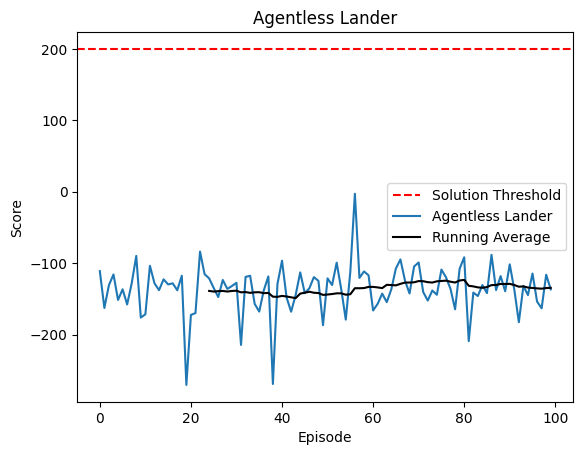

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -135.8
Maximum score: -2.8
Minimum score: -270.4
Average episode length: 71.0


In [11]:
# Instantiate agentless lunar lander
agentless_lander = LunarLander()

# Maintain list of agent objects
agents = [agentless_lander]

episodes = 100

# Iterate over selected number of episodes
agentless_lander.iterate(episodes, verbose = False, video = True, plot = True)

# Print average, max, min
average, max, min, avg_length = agentless_lander.score_stats(verbose = True)

[Link to the video of the agentless lander in the 64<sup>th</sup> episode](videos/agentless-lander-episode-64.mp4)

In the above graph, we can see that an agentless lunar lander is not sufficient to solve this problem. In the video linked above, we can see the lunar lander simply falling in a slightly curved trajectory toward the ground.

### Random Agent ###

Next, we consider the random agent which selects an action randomly.

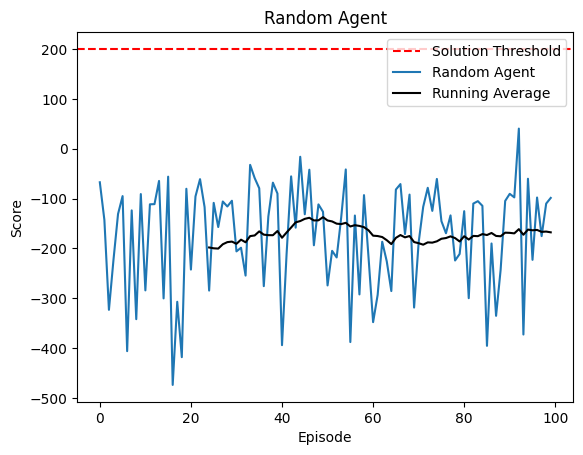

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -172.2
Maximum score: 40.3
Minimum score: -473.6
Average episode length: 89.2


In [12]:
# Instantiate lunar lander random agent
rand_agent = RandomAgent()

# Add to list of agents
agents.append(rand_agent)

# Iterate over episodes
rand_agent.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min, avg_length = rand_agent.score_stats(verbose = True)

[Link to the video of the random agent in the 64<sup>th</sup> episode](videos/random-agent-episode-64.mp4)

In [13]:
def plot_comparison(agents):
    '''
    Plot scores of multiple agent objects
    '''
    # Initialize plot
    plt.figure(1)
    plt.ylim([-600,300])

    # Plot solution threshold
    plt.axhline(y = 200, color = "r", linestyle = "dashed", label = "Solution Threshold")  

    # Initialize list of agent names
    names = []

    # Iterate over agents list
    for agent in agents:
        # Plot agent's scores
        plt.plot(agent.scores, label = agent.name)
        names.append(agent.name)

    plt.title(", ".join(names))
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.show();

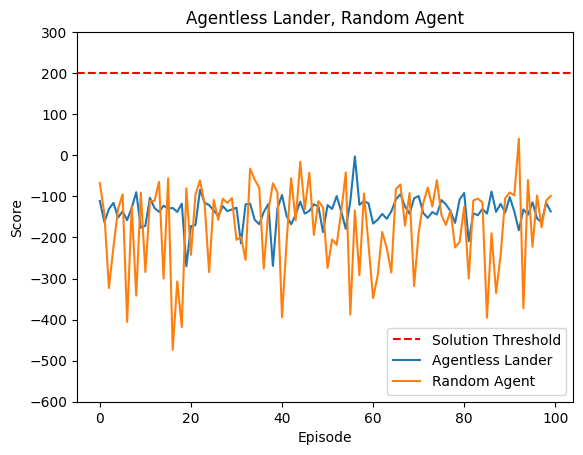

In [14]:
# Plot agentless lander and random agent scores over all episodes
plot_comparison(agents)

As the above graph shows, doing nothing is better than acting randomly in this environment. The agentless lunar lander is relatively more consistent and successful compared to the random agent and also has a slightly higher average score. Obviously, neither learn anything nor come remotely close to consistently reaching the solution threshold, as expected.

### Simple Reflex Agent ###

Next, we examine the agent which can reflexively fire its side engines in reaction to its current horizontal and angular velocity mediated by pre-selected threshold constants. Choosing ideal threshold constants requires tedious trial and error on the part of the programmer, rather than the agent. Thus, only the programmer is learning in this scenario.

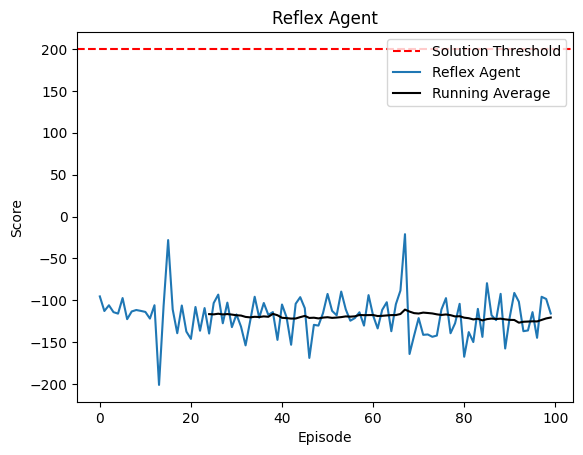

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -118.5
Maximum score: -21.0
Minimum score: -200.9
Average episode length: 69.1


In [15]:
# Instantiate lunar lander reflex agent
rflx_agent = ReflexAgent()

# Add to list of agents
agents.append(rflx_agent)

# Iterate over episodes
rflx_agent.iterate(episodes, verbose = False, video = True)

# Print average max, min
average, max, min, avg_length = rflx_agent.score_stats(verbose = True)

[Link to the video of the reflex agent in the 64<sup>th</sup> episode](videos/reflex-agent-episode-64.mp4)

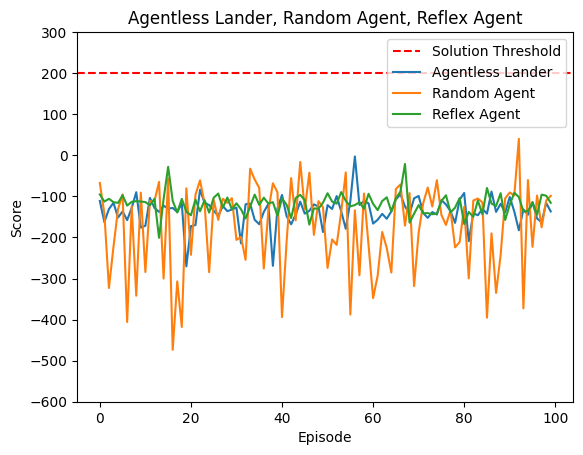

In [16]:
# Plot comparison of agents
plot_comparison(agents)

In the above graph, we can see that the reflex agent is only slightly more consistent and successful than the agentless lunar lander but still not even close to solving the problem. Additionally, it is clearly not learning, as expected. Landing a lunar rover appears to be more difficult than firing the left and right thrusters based on horizontal and angular velocity. It might be possible to achieve a higher score by comparing various algorithms and parameters through trial and error, but this would be a tedious process, so we would like to find a more expedient way to find the best policy to follow.

### Deep Q-Network Agent ###

Next, we examine the performance of a remembering, learning deep Q-network agent. We'll start with the following hyperparameters.

In [17]:
# Hyperparameters
name = "DQN Agent 1"
alpha = 0.1             # initial optimizer learning rate
epsilon = (0.99,        # epsilon-greedy max (starting value)
        0.01,           # epsilon-greedy min (ending value)
        0.001)          # exponential decay rate (smaller = slower)
gamma = 0.99            # discount rate
tau = 0.005             # target network update rate
lr_period = 100         # episodes between learning rate decreases
lr_decay = 0.1          # learning rate decay
batch_size = 128        # replay buffer batch size
buffer_size = 1000000   # replay buffer size (no. of transitions)

Let's confirm the neural network architecture and estimated computational requirements.

In [18]:
# Instantiate lunar lander DQN agent
dqn_agent1 = DQNAgent(name, alpha, epsilon, gamma, tau, lr_period, lr_decay, batch_size, buffer_size)

# View model summary
# https://github.com/TylerYep/torchinfo
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180/7

print("Model parameters on CUDA?",next(dqn_agent1.online_net.parameters()).is_cuda)
print(dqn_agent1.online_net)

from torchinfo import summary
import warnings

# Temporarily disable warnings to suppress this
# PyTorch warning: UserWarning: TypedStorage is deprecated. 
# It will be removed in the future and UntypedStorage will 
# be the only storage class. This should only matter to you 
# if you are using storages directly.  To access UntypedStorage 
# directly, use tensor.untyped_storage() instead of tensor.storage()
warnings.filterwarnings("ignore")

# Print TensorFlow-like model summary
summary(dqn_agent1.online_net, 
        input_size = (dqn_agent1.batch_size, dqn_agent1.features_size))


Device: cpu
Model parameters on CUDA? False
DQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [128, 4]                  --
├─Linear: 1-1                            [128, 128]                1,152
├─Linear: 1-2                            [128, 128]                16,512
├─Linear: 1-3                            [128, 4]                  516
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 2.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.07
Estimated Total Size (MB): 0.34

In [19]:
# Re-enable warnings
warnings.filterwarnings("default")

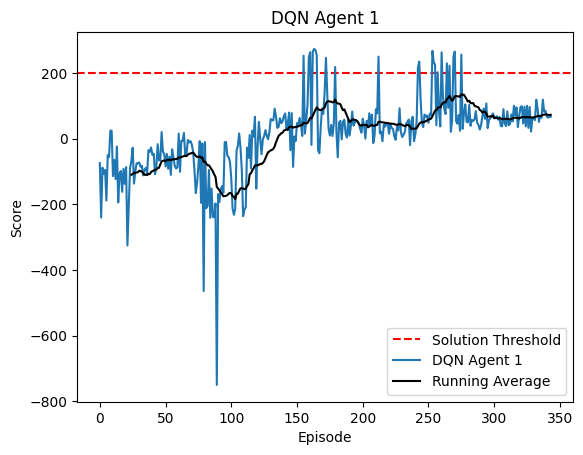

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: 10.1
Maximum score: 273.8
Minimum score: -750.3
Average episode length: 450.1


In [20]:
# Train DQN agent

# If GPU device is available
if torch.cuda.is_available():
    episodes = 513
    print("Device: cuda")
else:
    episodes = 344
    print("Device: cpu")

# Train for specified number of episodes
dqn_agent1.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min, avg_length = dqn_agent1.score_stats(verbose = True)

[Link to the video of the first DQN agent in the 343<sup>rd</sup> episode](videos/dqn-agent-1-episode-343.mp4)

This agent seemed to be headed in the right direction and even experienced some high scores above the solution threshold, but then it seemed to settle on a policy that resulted scores around 50 points. In the video linked above, we see the agent hovering just above the landing pad accumulating points for being close to the landing.

Let's give the agent some more incentive to finish the job and land by decreasing the discount rate $\gamma$. This should make hovering a less profitable activity.

In [23]:
# Hyperparameters
name = "DQN Agent 2"
alpha = 0.1             # initial optimizer learning rate
epsilon = (0.99,        # epsilon-greedy max (starting value)
        0.01,           # epsilon-greedy min (ending value)
        0.001)          # exponential decay rate (smaller = slower)
gamma = 0.8             # discount rate
tau = 0.005             # target network update rate
lr_period = 100         # episodes between learning rate decreases
lr_decay = 0.1          # learning rate decay
batch_size = 128        # replay buffer batch size
buffer_size = 1000000   # replay buffer size (no. of transitions)

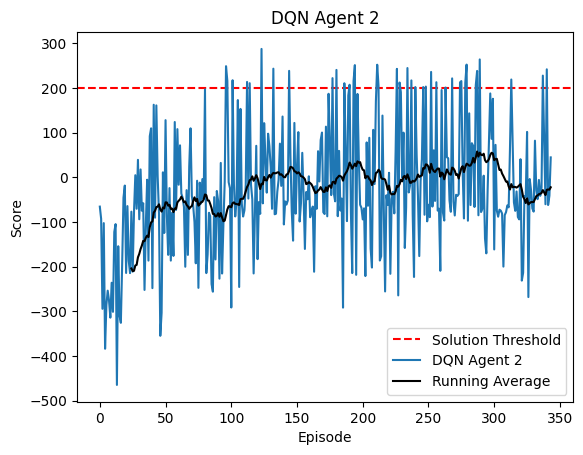

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -28.2
Maximum score: 287.7
Minimum score: -464.7
Average episode length: 486.2


In [24]:
# Instantiate second lunar lander DQN agent
dqn_agent2 = DQNAgent(name, alpha, epsilon, gamma, tau, lr_period, lr_decay, batch_size, buffer_size)

# Train for specified number of episodes
dqn_agent2.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min, avg_length = dqn_agent2.score_stats(verbose = True)

[Link to the video of the second DQN agent in the 343<sup>rd</sup> episode](videos/dqn-agent-2-episode-343.mp4)

Even though the average score is lower, there were more experiences above the threshold. In the video linked above, the agent is moving towards the ground, albeit slowly.  

Let's try decreasing the discount rate a little more and increasing the $\alpha$ learning rate decay period. This should give the agent a little more encouragement to land and more time to learn.

In [25]:
# Hyperparameters
name = "DQN Agent 3"
alpha = 0.1             # initial optimizer learning rate
epsilon = (0.99,        # epsilon-greedy max (starting value)
        0.01,           # epsilon-greedy min (ending value)
        0.001)          # exponential decay rate (smaller = slower)
gamma = 0.75            # discount rate
tau = 0.005             # target network update rate
lr_period = 200         # episodes between learning rate decreases
lr_decay = 0.1          # learning rate decay
batch_size = 128        # replay buffer batch size
buffer_size = 1000000   # replay buffer size (no. of transitions)

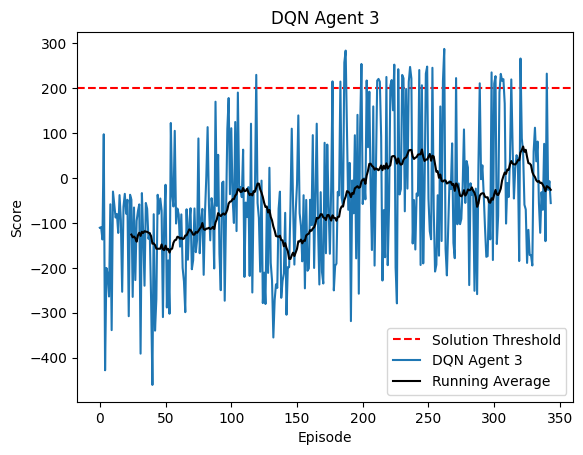

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -52.9
Maximum score: 286.8
Minimum score: -460.5
Average episode length: 404.4


In [26]:
# Instantiate lunar lander DQN agent
dqn_agent3 = DQNAgent(name, alpha, epsilon, gamma, tau, lr_period, lr_decay, batch_size, buffer_size)

# Train for specified number of episodes
dqn_agent3.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min, avg_length = dqn_agent3.score_stats(verbose = True)

[Link to the video of the third DQN agent in the 216<sup>th</sup> episode](videos/dqn-agent-3-episode-216.mp4)

[Link to the video of the third DQN agent in the 343<sup>rd</sup> episode](videos/dqn-agent-3-episode-343.mp4)

The average score was lower this time. The agent is experiencing more high scores, but perhaps because the state space is so large, it is having difficulty transfering the optimal actions for those transitions to other transitions in the environment. Looking at the videos, in the Episode 216 video, the agent lands, but in the 343rd episode, it is just hovering near the top center.

Let's try decreasing the discount rate more, decreasing the greedy-epsilon decay rate to encourage more exploration, increasing the target network update rate, and increasing the buffer and batch sizes to try to remember more optimal actions.

In [27]:
# Hyperparameters
name = "DQN Agent 4"
alpha = 0.1             # initial optimizer learning rate
epsilon = (0.99,        # epsilon-greedy max (starting value)
        0.01,           # epsilon-greedy min (ending value)
        0.0001)         # exponential decay rate (smaller = slower)
gamma = 0.7             # discount rate
tau = 0.01              # target network update rate
lr_period = 200         # episodes between learning rate decreases
lr_decay = 0.1          # learning rate decay
batch_size = 256        # replay buffer batch size
buffer_size = 10000000  # replay buffer size (no. of transitions)

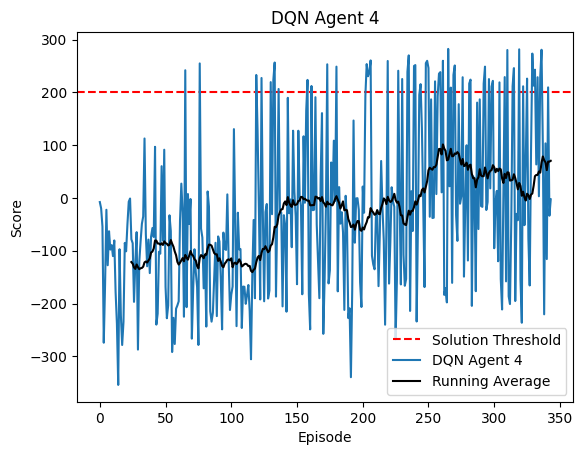

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -28.9
Maximum score: 282.6
Minimum score: -354.2
Average episode length: 348.9


In [28]:
# Instantiate lunar lander DQN agent
dqn_agent4 = DQNAgent(name, alpha, epsilon, gamma, tau, lr_period, lr_decay, batch_size, buffer_size)

# Train for specified number of episodes
dqn_agent4.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min, avg_length = dqn_agent4.score_stats(verbose = True)

[Link to the video of the fourth DQN agent in the 343<sup>rd</sup> episode](videos/dqn-agent-4-episode-343.mp4)

Things are looking up. The average score is higher than Agent 3's. There also seems to be an overall trend upward. The average episode length has decreased as well, which suggests there may be less hovering and more landing. Supporting this hypothesis, the lander in the video clip lands in the landing pad, a little roughly, but both of the legs are intact and on the ground.

Let's give the agent more memory by increasing the batch and replay buffer size again. We'll also train for longer to give the agent more time to master the task.

In [30]:
# Hyperparameters
name = "DQN Agent 5"
alpha = 0.1             # initial optimizer learning rate
epsilon = (0.99,        # epsilon-greedy max (starting value)
        0.01,           # epsilon-greedy min (ending value)
        0.0001)         # exponential decay rate (smaller = slower)
gamma = 0.7             # discount rate
tau = 0.01              # target network update rate
lr_period = 200         # episodes between learning rate decreases
lr_decay = 0.1          # learning rate decay
batch_size = 512        # replay buffer batch size
buffer_size = 100000000 # replay buffer size (no. of transitions)

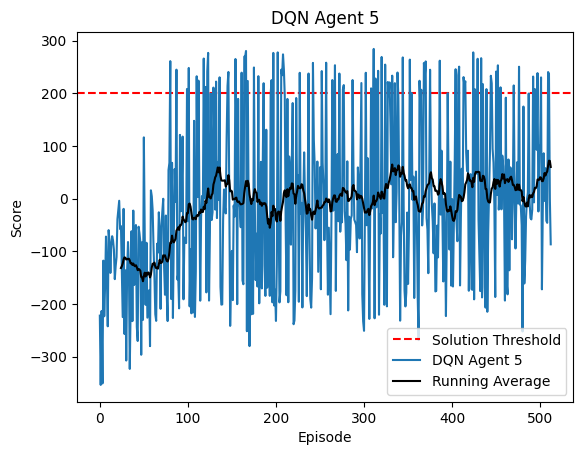

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Average score: -11.4
Maximum score: 284.3
Minimum score: -353.5
Average episode length: 374.3


In [31]:
# Reset the second lunar lander DQN agent
dqn_agent5 = DQNAgent(name, alpha, epsilon, gamma, tau, lr_period, lr_decay, batch_size, buffer_size)
  
# If GPU device is available
if torch.cuda.is_available():
    episodes = 730
    print("Device: cuda")
else:
    episodes = 513
    print("Device: cpu")

# Train for specified number of episodes
dqn_agent5.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min, avg_length = dqn_agent5.score_stats(verbose = True)


[Link to the video of the fifth DQN agent in the 343<sup>rd</sup> episode](videos/dqn-agent-5-episode-353.mp4)

[Link to the video of the fifth DQN agent in the 512<sup>th</sup> episode](videos/dqn-agent-5-episode-512.mp4)

The average has increased slightly compared to Agent 4 and the average episode length has decreased. However, we are still a long ways from consistently solving the problem. More tuning is necessary and a longer training time, but we will leave that for another day and another report.

## Discussion ## 

As predicted, the DQN agent performed better than the non-learning agents. Of the four types, the random agent performed the worst.Surprisingly, the reflex agent was not much better than an agentless lunar lander falling to the ground.

In tuning the DQN agent hyperparameters, it tentatively appears that incentivizing landing through a lower discount rate, giving more time for learning by slowing the learning rate decay, encouraging exploration through a slower epsilon-greedy decay rate, and increasing memory capacity through larger batch samples and replay buffer size all contributed toward achieving higher scores. More tuning is necessary, however. In particular, it will be important to determine to what extent each of these hyperparameters contribute as well as any interactions.

Although the non-learning agent results are somewhat trivial, they provide a useful baseline for comparison with reinforcement learning agents. In addition, coding and running the non-learning agents allowed me to set up and confirm the environment, agent class objects, and visualization tools were working before taking on the more daunting task of designing a DQN model. 

Coding and then tuning the DQN agent hyperparameters was particularly challenging. This is in part due to the fact that it takes hundreds of episodes of training before trends or problems might appear. An agent that appears to be doing well in the first 100 episodes, might prove to be worthless after 500 episodes. I would have liked to explore hyperparameter tuning more, but time and computer resources were limiting factors.

### Suggestions for Future Work ###

There are a number of directions for future research:

I have only explored a few optimizations in this paper. There are still many ways to improve upon the DQN model presented here, ranging from more hyperparameter tuning to the exploration of different optimization algorithms and neural network architectures. More rigorous model testing is also needed. In addition, the Gymnasium lunar lander environment is deterministic. In such environments, Machado and his colleagues (2018) recommend introducing stochasticity with frame skipping and sticky actions that repeat with a given probability in order to test the robustness of models in more realistic environments. Another direction for exploration is applying convolutional neural networks and comparing the results with the state features-based model.

More complex Gymnasium environments, such as the "Arcade Learning Environment" (Bellemare, 2023; Bellemare et al., 2013; Machado et al., 2018), which simulates classic Atari 2600 games (AtariAge, 2023), can also provide opportunities to explore more challenging problems. 

### Conclusion ###
This project compared four different artificial agents in a lunar lander simulation. As expected, the deep reinforcement learning agent performed better than the three non-learning agents. Of the three non-learning agents, the simple reflex agent was only slightly better than an agentless lunar lander, and acting randomly was the worst strategy. A deep Q-network with three fully-connected neural network layers was used for the learning agent.

Finally, it is only natural to ask: What is the value of crashing a virtual lunar lander model hundreds of times in order to eventually land successfully? There are two main reasons. First, it is better to train a far less-expensive virtual model and then transfer that learning to a real-world environment. Thus, the long-term aim is to develop the ability to transfer this virtual knowledge to a real-world environment. Second, through this project, I have gained skills and experience with deep reinforcement learning that I can build on to explore more sophisticated artificial intelligence algorithms in the future.

## References ##

_AtariAge._ (2023). [Website]. [https://atariage.com](https://atariage.com)

Bellemare, M. G. (2023). Arcade Learning Environment. [https://github.com/mgbellemare/Arcade-Learning-Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)

Bellemare, M. G., Naddaf, Y., Veness, J., & Bowling, M. (2013). The Arcade Learning Environment: An evaluation platform for general agents. _Journal of Artificial Intelligence Research, 47,_ 253-279.
[https://doi.org/10.1613/jair.3912](https://doi.org/10.1613/jair.3912)

Brownlee, J. (2017, July 3). Gentle introduction to the Adam optimization algorithm for deep learning. _Machine Learning Mastery._ [https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

Goodfellow, I., Bengio, Y., & Courville, A. (2016). _Deep learning._ MIT Press. [http://www.deeplearningbook.org](http://www.deeplearningbook.org)

_Gymnasium._ (2022). Farama Foundation. [https://gymnasium.farama.org/](https://gymnasium.farama.org/)

Heintz, B. (2021, April 17). _Building models with Pytorch._ Pytorch. [https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#building-models-with-pytorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#building-models-with-pytorch)

Huber, P. J. (1964). Robust estimation of a location parameter. _Annals of Statistics, 53_(1), 73–101. [https//doi.org/10.1214/aoms/1177703732](https//doi.org/10.1214/aoms/1177703732)

Karpathy, A. (2016). _Convolutional neural networks for visual recognition._ Stanford University. [https://cs231n.github.io/convolutional-networks/](https://cs231n.github.io/convolutional-networks/)

Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. _International Conference on Learning Representations._[https://doi.org/10.48550/arXiv.1711.05101](https://doi.org/10.48550/arXiv.1711.05101)

Machado, M. C., Bellemare, M. G., Talvitie, E., Veness, J., Hausknecht, M., & Bowling, M. (2018). Revisiting the Arcade Learning Environment: Evaluation protocols and open problems for general agents. _Journal of Artificial Intelligence Research, 61,_ 523–562. [https://doi.org/10.1613/jair.5699](https://doi.org/10.1613/jair.5699)

Matplotlib. (2023). _API reference._ [https://matplotlib.org/stable/api/index](https://matplotlib.org/stable/api/index)

Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S., & Hassabis, D. (2015). Human-level control through deep reinforcement learning. _Nature, 518_, 529–533. [https://doi.org/10.1038/nature14236](https://doi.org/10.1038/nature14236)

Mnih, V., Puigdomènech Badia, A., Mirza, M., Graves, A., Harley, T., Lillicrap, T. P., Silver, D., & Kavukcuoglu, K. (2016). Asynchronous methods for deep reinforcement learning. _Proceedings of the 33rd International Conference on Machine Learning, 48,_ 1928–1937. [https://proceedings.mlr.press/v48/mniha16.html](https://proceedings.mlr.press/v48/mniha16.html)

Morales, M. (2020). _Grokking deep reinforcement learning._ Simon and Schuster.

Paszke, A., & Towers, M. (2017, April 6). _Reinforcement learning (DQN) tutorial._ Pytorch. [https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

Pytorch. (2023). _Pytorch documentation._ [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

Reddi, S. J., Kale, S., & Kumar, S. (2019). On the convergence of adam and beyond. _International Conference on Learning Representations._[https://doi.org/10.48550/arXiv.1904.09237](https://doi.org/10.48550/arXiv.1904.09237)

Russell, S., & Norvig, R. (2022). _Artificial intelligence: A modern approach,_ (4th ed.). Pearson. 

Sutton, R. S., & Barto, A. G. (2018). _Reinforcement learning: An introduction._ MIT Press.

Tam, A. (2023, February 22). Using learning rate schedule in Pytorch training. _Machine Learning Mastery._ [https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/](https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/)